<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Model" data-toc-modified-id="Image-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Model</a></span><ul class="toc-item"><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Image-Augmentation" data-toc-modified-id="Image-Augmentation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Image Augmentation</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Transfer Learning</a></span><ul class="toc-item"><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Feature Extraction</a></span></li><li><span><a href="#Fine-Tuning" data-toc-modified-id="Fine-Tuning-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Fine Tuning</a></span></li></ul></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,keras,joblib

Using TensorFlow backend.


Ethen 2018-08-30 19:42:00 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2
keras 2.2.2
joblib 0.11


The text content of this notebook is mainly a rehash of the resources listed at the following link. [Github: Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks). As for the code part, this notebook refactors the original code in hope of making it more modular.

# Image Model

This notebook explores two topics: **Image Augmentation** and **Transfer Learning**.

We'll often times hear that deep learning requires a lot of data for it to work. This is a valid point as one characteristic of deep learning is that it is capable of finding interesting features in the training data on its own, without the need for manual feature engineering, and this can only be achieved when lots of training examples are available at hand, or else there might be a risk that our model will be biased towards the small amount of data we give, resulting in poor generalization.

The hunger for data is especially true for problems where input samples are high-dimensional, like images. What constitutes "lots" of samples, however, is relative to the complexity of the network we are trying to train. It isn't impossible to train a good convolutional neural network (convnets) to solve a problem with just a few hundreds of examples if the model is small and well-regularized, because convnets can learn local, translation-invariant features that are very data-efficient on computer vision problems.

But, it turns out, there are additional approaches that we can take to tackle the "small" data problem.

- Image Augmentation: This is a technique that generates more data from our existing ones, for example. Given an image, we can rotate it, shift it up, down, left or right. And during training, we will use these additional "augmented" images.
- Transfer Learning: deep learning models are by nature highly re-purposable: we can take, say, an image classification trained on a large-scale dataset then reuse it on a significantly different problem with minor tweaks. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to create powerful computer vision models out of very little data.

For now, let's get started by getting our hands on the data. The data that we'll be using is the cats versus dogs dataset, which we can access from Kaggle at https://www.kaggle.com/c/dogs-vs-cats/data. After downloading the dataset, we will load some images in to see what our dataset looks likes.

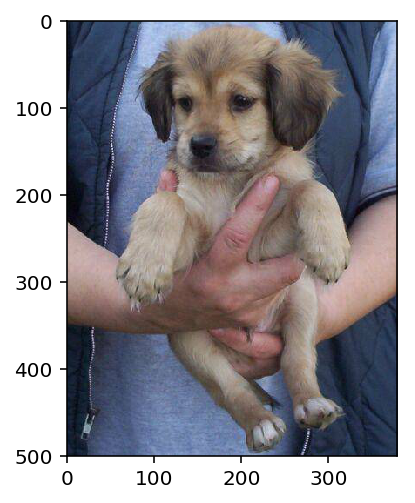

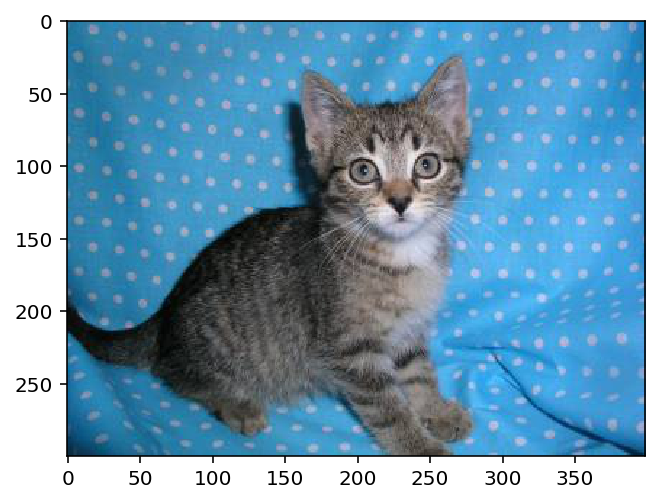

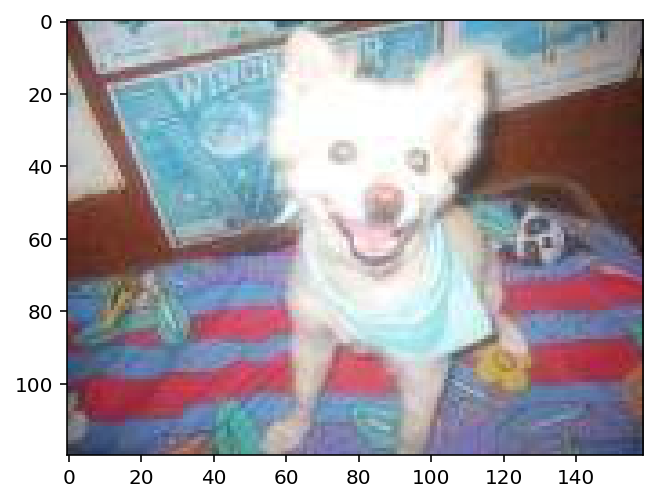

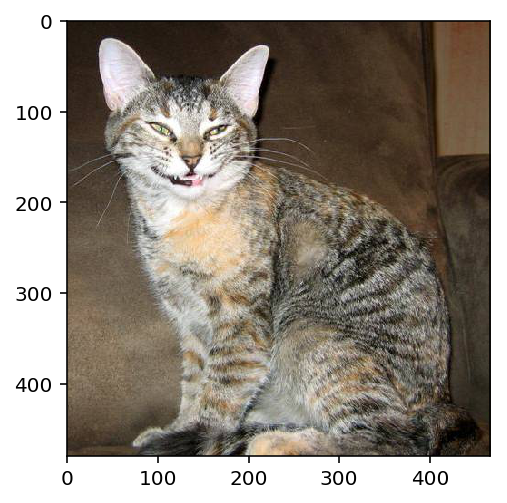

In [2]:
from PIL import Image


# base path that stores the cats & dogs dataset downloaded from kaggle
original_img_dir = os.path.join('all', 'train')

# for variable name, 'image' are named 'img' as per keras convention
img_paths = ['dog.8011.jpg', 'cat.5077.jpg', 'dog.7322.jpg', 'cat.2718.jpg']
for img_path in img_paths:
    img_input_path = os.path.join(original_img_dir, img_path)
    img = np.array(Image.open(img_input_path))
    plt.imshow(img)
    plt.show()

As we can probably guess from the competition's name the task at hand is given some medium-sized cats/dogs pictures we need to build a image classifier that is capable of differentiating the two.

## Data Preprocessing

This section does some simple preprocessing, including:

- Setting up the training, validation and test dataset.
- Organizing the image into a more keras friendly way (more on this in its section later).

In [3]:
def create_data_and_label(original_img_dir, ids_col='img_path', label_col='label'):
    """
    Creates a dataframe that contains the file name and its corresponding label.
    Note that the way we extracted the labels here is specific to this dataset,
    though we can change the logic to make it applicable for other dataset.
    """
    result = []
    for img_path in os.listdir(original_img_dir):
        # avoid hidden files like .DSstore files
        # that are generated on mac
        if img_path.startswith('.'):
            continue

        # data-specific label parsing logic
        if img_path.startswith('cat'):
            label = 'cat'
        elif img_path.startswith('dog'):
            label = 'dog'
        else:
            raise ValueError('there should only be cat or dog for the label')

        result.append((img_path, label))

    data_and_label = pd.DataFrame(result, columns=[ids_col, label_col])
    return data_and_label


ids_col = 'img_path'
label_col = 'label'
data = create_data_and_label(original_img_dir)
print('dimension: ', data.shape)
data.head()

dimension:  (25000, 2)


,img_path,label
0,dog.8011.jpg,dog
1,cat.5077.jpg,cat
2,dog.7322.jpg,dog
3,cat.2718.jpg,cat
4,cat.10151.jpg,cat


In [4]:
def train_val_test_split(data, val_size=0.2, test_size=0.1, random_state=1234, label_col=None):
    """
    Train/test split twice to achieve train/validation/test three way split.

    For classification task, we can pass in label_col to perform a stratified split,
    whereas for regression task, we can ignore the argument to perform a random split.
    """
    stratify = None
    if label_col is not None:
        stratify = data[label_col]

    data_train, data_test = train_test_split(
        data, test_size=test_size, random_state=random_state, stratify=stratify)

    if label_col is not None:
        stratify = data_train[label_col]

    data_train, data_val = train_test_split(
        data_train, test_size=val_size, random_state=random_state, stratify=stratify)
    return data_train, data_val, data_test


val_size = 0.2
test_size = 0.1
split_random_state = 1234

df_train, df_val, df_test = train_val_test_split(
    data, val_size, test_size, split_random_state, label_col)

df_groups = (df_train, df_val, df_test), ('train', 'validation', 'test')
for df_subset, df_type in zip(*df_groups):
    print(df_type + ' dimension: {}, {}'.format(*df_subset.shape))

train dimension: 18000, 2
validation dimension: 4500, 2
test dimension: 2500, 2


After doing our train/validation/test set split, we will organize our data into the following format:

```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    test/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```

Under our main data folder, we split it into a training, validation and test set directory containing one subdirectory per image class. As we'll soon see this will make it easier for us to leverage some of keras' `ImageGenerator`, which allows us to load images in batches from disk as oppose to reading the everything into memory.

In [5]:
from shutil import copyfile
from joblib import Parallel, delayed


def create_all_keras_file(img_ids, labels, unique_labels,
                          keras_dir, img_dir, folder_name,
                          n_jobs=-1, verbose=True, pre_dispatch='2*n_jobs'):
    """
    Create the keras way of organizing the files so it
    can be called via keras' ImageDataGenerator, which
    allows for not reading in the images into memory all at
    once; the way it is done is by storing training
    and test set in separate sub-folder and under
    each sub-folder is a folder for each class/label's images.

    Parameters
    ----------
    img_ids : list[str]
        Sequence of image ids, i.e. images' file names. Note that
        this assumes the file name already contains the file extension
        and it is not yet the full path. e.g. one img_id might look like
        dog.8011.jpg, whereas the full path to actually read the image
        is data/dog.8011.jpg. This prevents storing the 'data' string
        across all of our image path.

    labels : list[str]
        Images' corresponding label, length should match img_ids.

    unique_labels : list[str]
        Unique labels in the dataset, the name will be used to 
        generate the sub-folder that identifies each class.

    keras_dir : str
        Filepath that the keras' folder will be created.

    img_dir : str
        Filepath that contains the original images.

    folder_name : str
        Folder name of the 1st level sub-folder after the keras_dir,
        e.g. setting it to 'train' to indicate that this will be the
        training data set (all the images of the training dataset will
        go under this folder).

    n_jobs, verbose, pre_dispatch
        Joblib parameter for parallelizing the process.

    Returns
    -------
    data_dir : str
        Path of the folder_name, can/will be used for passing it to
        keras' ImageDataGenerator for reading batches of images.
    """
    # data_dir refers to whether it's storing the training or testing data
    data_dir = os.path.join(keras_dir, folder_name)
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

        # create a sub-folder inside data_dir for every unique labels
        for label in unique_labels:
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                os.mkdir(label_dir)

        # copying file is IO-bound, thus we are not blocked by the GIL
        # and can leverage the faster multi-threading instead of multi-processing
        parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
                            pre_dispatch=pre_dispatch, backend='threading')
        parallel(delayed(create_keras_file)(img_id, label, img_dir, data_dir)
                 for img_id, label in zip(img_ids, labels))

    return data_dir


def create_keras_file(img_id, label, img_dir, data_dir):
    """
    Copy the image from the orginal folder to the
    corresponding keras folder.
    """
    src_path = os.path.join(img_dir, img_id)
    dest_path = os.path.join(data_dir, label, img_id)

    # the following link contains a pretty good overview of copying single
    # files in python
    # https://www.pythoncentral.io/how-to-copy-a-file-in-python-with-shutil/
    copyfile(src_path, dest_path)

In [6]:
unique_labels = data[label_col].unique()
n_classes = unique_labels.shape[0]
print('number of distinct classes: ' + str(n_classes))
print('unique labels: ' + str(unique_labels))

# set a new folder for storing images in
# keras' ImageGenerator way and reate the
# folder for all train/validation/test set
keras_dir = 'keras_img'
if not os.path.isdir(keras_dir):
    os.makedirs(keras_dir, exist_ok=True)

# keras_img_dirs will store our train/validation/test
# set's directory path
keras_img_dirs = {}
for df_subset, df_type in zip(*df_groups):
    img_ids = df_subset[ids_col].values
    labels = df_subset[label_col].values

    keras_img_dir = create_all_keras_file(
        img_ids, labels, unique_labels, 
        keras_dir, original_img_dir, df_type, verbose=0)

    keras_img_dirs[df_type] = keras_img_dir

keras_img_dirs

number of distinct classes: 2
unique labels: ['dog' 'cat']


{'train': 'keras_img/train',
 'validation': 'keras_img/validation',
 'test': 'keras_img/test'}

## Image Augmentation

One possible reason that can cause our convnet to overfit is by having too few samples to learn from. Image augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of transformations that generates believable-looking images. The goal is that at training time, our model would never see the exact same picture twice, while helping the model get exposed to more aspects of the data and generalize better.

Fortunately, keras already has an `ImageDataGenerator` helper class to make this easier for the end-user.

In [7]:
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

These are just a few of the options available (for more, see the [Keras documentation on ImageGenerator](https://keras.io/preprocessing/image/)). Let's quickly go over what we just wrote:

- `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
- `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- `shear_range` is for randomly applying shearing transformations.
- `zoom_range` is for randomly zooming inside pictures.
- `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).
- `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

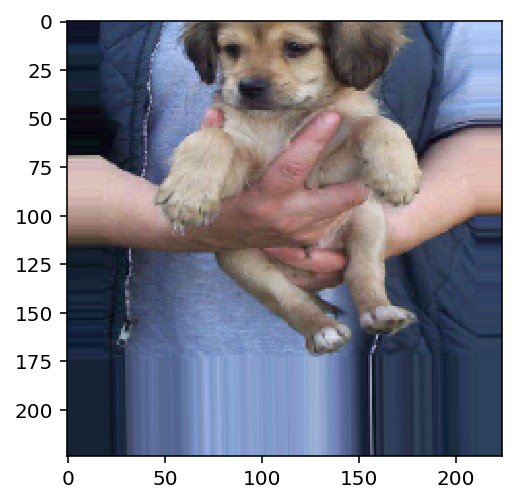

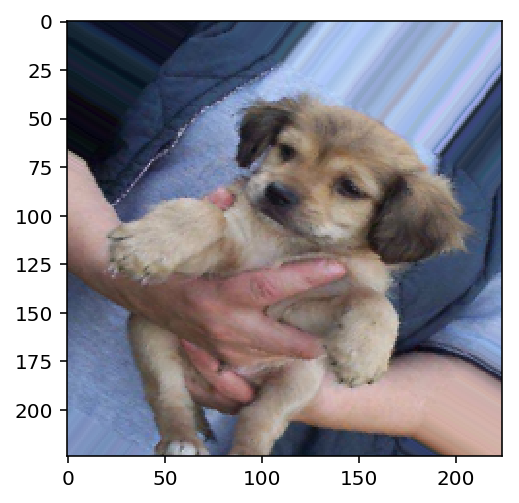

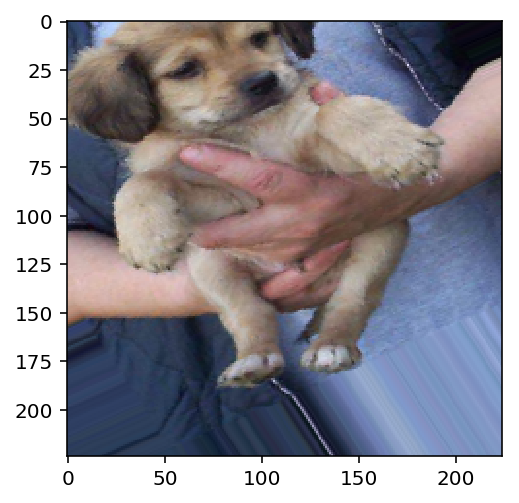

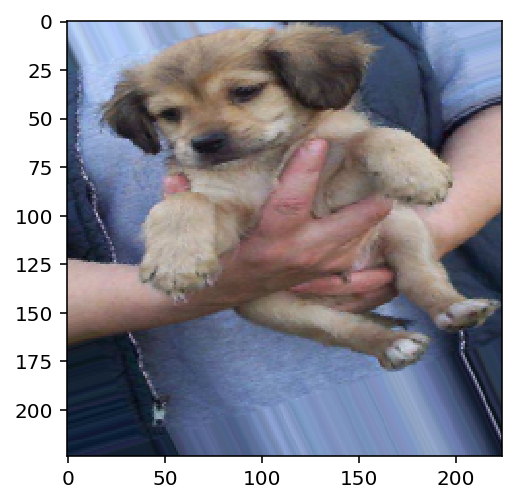

In [8]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img


# we'll pick one image to "augment"
img_input_path = os.path.join(original_img_dir, 'dog.8011.jpg')

# read the image and resize it to a square image,
# as we'll soon see, there's a reason why 224, 224 was chosen
img = load_img(img_input_path, target_size=(224, 224))

# convert it to a numpy array of shape (224, 224, 3),
# and reshape it to (1, 224, 224, 3), since ImageDataGenerator
# expects numpy array of rank 4, with the first size indicating
# the batch size
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images.
# it will loop indefinitely, so we need to `break` the loop at some point
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    plt.imshow(array_to_img(batch[0]))
    i += 1

    # only show 4 images
    if i % 4 == 0:
        break

plt.show()

In [9]:
# we'll re-create the actual ImageDataGenerator
# rescaling can be seen as standarding the image dataset
rescale = 1. / 255
train_datagen = ImageDataGenerator(
      rescale=rescale,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# note that the validation data should not be augmented!
# we will only use it for rescaling
test_datagen = ImageDataGenerator(rescale=rescale)

Apart from using the `.flow` method that works with numpy arrays, it also has the `.flow_from_directory` method that automatically turn image files on disk into batches of pre-processed numpy arrays. We can pass the keras image directory we created to our `ImageDataGenerator` object so it knows where to generate the images from and pass some additional parameters including: 

- `target_size`: All images will be resized to 224 x 224, as this was the size of the image that the network we'll be using was trained on, more details in the next section.
- `batch size`: is a configurable parameter.
- `class_mode`: Since we use binary_crossentropy loss, we need binary labels.

In [10]:
target_size = 224, 224
batch_size = 32

generator_params = {
    'target_size': target_size,
    'batch_size': batch_size,
    'class_mode': 'binary'
}
train_generator = train_datagen.flow_from_directory(
        keras_img_dirs['train'], **generator_params)

val_generator = test_datagen.flow_from_directory(
        keras_img_dirs['validation'], **generator_params)

# some potentially useful attributes that we can obtain
# from the generator
print('number of classes: ', train_generator.num_classes)
print('class indices:')
train_generator.class_indices

Found 18000 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.
number of classes:  2
class indices:


{'cat': 0, 'dog': 1}

We can look at the output of one of these generators by looping over it. It yields batches of 224 times 224 RGB images. The first number 32 is the `batch_size` that we've specified. Note that since the generator yields these batches indefinitely as it loops endlessly over the images present in the target folder. For this reason, we need to explicitly break the iteration loop. 

In [11]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


Now that we've setup the `ImageDataGenerator` let's move on to our next important topic, **Transfer Learning**.

## Transfer Learning

A common and effective technique used in the deep learning community is **Transfer Learning**. The idea is to leverage a pre-trained network, i.e. a neural network model that have been trained on a large-scale image classification task. If the original dataset is large and general enough, then the features learned by the pre-trained network can be used as features different computer vision problems, even if the the problem that we're trying to solve might involve a different classes from the original task. For instance, a network trained on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something such as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, thus we can expect it to perform well on our cat vs. dog classification problem.

We will use the VGG16 architecture, although it is a bit of an older model (first introduced in 2014), far from the current state of the art and somewhat heavier than many other recent models, we chose it because its architecture is similar to what we've are already familiar with, this allows us to focus on the task at hand. 

> Side Note: Like many machine learning algorithms, convnet also have a lot of parameters that we can tweak. Instead of coming up with our own architecture we often times can leverage other people's design. Architectures such as VGG, ResNet, Inception are common ones we'll encounter and these names will come up frequently if we are doing deep learning for computer vision. The details of the other networks will not be covered in this notebook

There are two ways to leverage a pre-trained network: feature extraction and fine-tuning. We will cover both of them. Let's start with feature extraction.

### Feature Extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output. This idea can be summarized into the following diagram:

<img src="img/feature_extraction.png" width="20%" height="20%">

One question you might have is why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore re-usability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model (earlier meaning closer to the input data) extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if our new dataset differs a lot from the dataset that the original model was trained on, we may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put these concepts in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from our cat and dog images, and then training a cat vs. dog classifier on top of these features. The VGG16 model, among others, comes pre-packaged with Keras. We can import it from the `keras.applications` module.

We passed three arguments to the VGG16 model constructor:

- `weights`: to specify which weight checkpoint to initialize the model from. If this the first time we're running the command then keras will attempt to download the pre-trained network's weight from the internet.
- `include_top`: which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
- `input_shape`: the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Apart from that, we also use the `.summary()` method to print the detail of the architecture of the VGG16 convolutional base.

In [12]:
from keras.applications import VGG16

# the following code is commented out, after downloading the weights
# from the internet, weight_path shows where keras will be loading
# the weights from from then on, we can also pass the weight's path
# on disk to the `weights` argument

# home_dir = os.path.expanduser('~')
# keras_model_base_dir = os.path.join(home_dir, '.keras', 'models')
# weight_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# weight_path = os.path.join(keras_model_base_dir, weight_file)

input_shape = target_size[0], target_size[1], 3
conv_base = VGG16(weights='imagenet',  # weight_path
                  include_top=False,
                  input_shape=input_shape)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Because the `conv_base` we've just defined behaves just like layers, we can call the method `.add` from our `Sequential` model on it, and add our dense layers after that.

In [13]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


As we can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The additional layers we are adding on top has 2 million parameters.

Before we compile and train our model, one very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [14]:
print('number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

number of trainable weights before freezing the conv base: 30
number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify whether our model weights' are trainable or not after compilation, we should re-compile the model, or these changes would be ignored.

In [15]:
# should call .compile after setting whether layer is trainable
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy'])

In [16]:
hi

NameError: name 'hi' is not defined

To fit our model to the data using the generator we've defined earlier. We use the `.fit_generator` method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely. Apart from that, we can also specify a `validation_data` to evaluate our model during on a hold-out dataset during the training process. And last but not least is the number of `epochs` to train the model and `verbose` it controls whether to show progress bars during training.

In [ ]:
history = model.fit_generator(
      train_generator,
      epochs=2,
      validation_data=val_generator,
      verbose=1)

In [ ]:
def viz_history(history, fig_path=None): 
    fig, ax = plt.subplots(1, 2, figsize = (10, 6))
    fig.suptitle('Training History')

    ax[0].plot(history['loss'], label = 'Train')
    ax[0].plot(history['val_loss'], label = 'Test')
    ax[0].set_title('Training Loss History')
    
    best_acc = np.max(history['val_acc']) * 100
    ax[1].plot(history['acc'], label = 'Train')
    ax[1].plot(history['val_acc'], label = 'Test')    
    ax[1].set_ylim([0, 1.1]) 
    ax[1].set_title('Training Accuracy History\nBest Test Accuracy: {:0.2f}%'.format(best_acc))     
    ax[1].legend(loc = 'lower right', fontsize = 12)

    if fig_path is not None:
        plt.savefig(fig_path)

    plt.show()
    
    
#fig_path = 'history_{}.png'.format(model_name)
viz_history(history.history)

### Fine Tuning

Another widely used technique for model reuse, complementary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the convolutional base's top layers that we're currently using for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected layer) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand. In the case of the VGG16 model we are using, it might be something like the following diagram:

<img src="img/fine_tuning.png" width="30%" height="30%">

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to train a randomly initialized classifier on top of it. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

1. Add our custom network on top of an already trained base network.
2. Freeze the base network.
3. Train the part we've just added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our conv_base, and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

- Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters we are training, the more we are at risk of overfitting. The convolutional base has almost 15M parameters, so it would be risky to attempt to train it on our small dataset.

Thus, in our situation, a good strategy should be to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptive learning rate optimizer such as RMSProp. This is to ensure the the magnitude of updates we make to the representations of the 3 layers that we are fine-tuning stays small. Updates that are too large may harm these representations.

In [21]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4),
    metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 13,502,465
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# history = model.fit_generator(
#       train_generator,
#       epochs=2,
#       validation_data=validation_generator,
#       verbose=1)

**Takeaways:**

- Convnets are arguably the best type of machine learning models for computer vision tasks as of now. It is possible to train one from scratch even on a very small dataset, with decent results.
- On a small dataset, overfitting our data is often times a major concern. Data augmentation is a powerful way to reduce overfitting when working with image data. The caveat here is that we cannot produce new information, as we are only remixing existing information. As such, this technique may not be enough to completely get rid of overfitting.
- It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
- As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

# Reference

- [Blog: Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
- [Notebook: Using convnets with small datasets](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb)
- [Notebook: Using a pre-trained convnet](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)